In [1]:
! pip install celluloid

In [26]:
! pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 848.3 kB/s eta 0:00:00a 0:00:01


In [2]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

from IPython.display import HTML

In [3]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# import imgaug
# import imgaug.augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [27]:
import torchio as tio # for dataset creation and volume handling

In [4]:
root = Path("../input/medical-segmentation-decathlon-3dliver/imagesTr/")
label = Path("../input/medical-segmentation-decathlon-3dliver/labelsTr/")

### Data Visualization

In [5]:
def change_img_to_label_path(path):
    
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [6]:
sample_path= list(root.glob("*/liver_*"))[0]
sample_path_label = change_img_to_label_path(sample_path)

In [8]:
sample_path, sample_path_label

(PosixPath('../input/medical-segmentation-decathlon-3dliver/imagesTr/liver_50.nii/liver_50.nii'),
 PosixPath('../input/medical-segmentation-decathlon-3dliver/labelsTr/liver_50.nii/liver_50.nii'))

In [9]:
# Load NifTI and extract image data
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata().astype(int)

In [10]:
ct.shape, mask.shape

((232, 232, 200), (232, 232, 200))

In [11]:
# Find out orientation  
# Orientation: Right to Left=Sagittal, Anterior to Posterior=Coronal, Supeior to Inferior=Axial
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

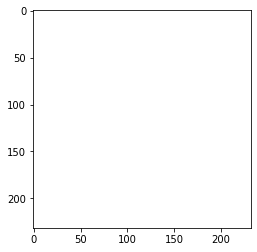

In [12]:
fig = plt.figure()
camera = Camera(fig)

for i in range(0, ct.shape[2], 2): # axial view
    plt.imshow(ct[:, :, i], cmap="bone") 
    mask_ = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    camera.snap()

animation = camera.animate()

In [13]:
HTML(animation.to_html5_video())

### Model

In [21]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.step = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv3d(out_channels, out_channels, 3, padding=1),
            torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)

In [22]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.layer1 = DoubleConv(1, 32)
        self.layer2 = DoubleConv(32, 64)
        self.layer3 = DoubleConv(64, 128)
        self.layer4 = DoubleConv(128, 256)
        
        # decoder
        self.layer5 = DoubleConv(256+128, 128)
        self.layer6 = DoubleConv(128+64, 64)
        self.layer7 = DoubleConv(64+32, 32)
        self.layer8 = torch.nn.Conv3d(32, 3, 1)
        
        self.maxpool =  torch.nn.MaxPool3d(2)
        
    def forward(self, x):
        
        # encoder
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        # decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

In [23]:
model = UNet()

In [24]:
random_input = torch.randn(1, 1, 128, 128, 128)
output = model(random_input)
assert output.shape == torch.Size([1, 3, 128, 128, 128])

### TorchIO Dataset Creation

In [28]:
path = Path("../input/medical-segmentation-decathlon-3dliver/imagesTr/")
subject_paths = list(path.glob("*/liver_*"))

subjects = []

for subject_path in subject_paths:
  label_path = change_img_to_label_path(subject_path)
  subject = tio.Subject({"CT": tio.ScalarImage(subject_path), "Label": tio.LabelMap(label_path)})
  subjects.append(subject)

In [29]:
for subject in subjects:
  assert subject["CT"].orientation == ("R", "A", "S")

In [37]:
process = tio.Compose([
    tio.CropOrPad((256, 256, 200)),
    tio.RescaleIntensity((-1, 1)),
])

augmentation = tio.RandomAffine(scales=(0.9, 1,1), degrees=(-10, 10))

val_transform = process
train_transform = tio.Compose([process, augmentation])

In [38]:
train_dataset = tio.SubjectsDataset(subjects[:105], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

In [39]:
sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", 
                                label_probabilities={0:0.2, 1:0.3, 2:0.5}) # prob = bkg, liver, tumors
# sampler = tio.data.UniformSampler(patch_size=96)

Create queue to draw patches from

In [40]:
train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

In [41]:
# define train and val loader
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)

Segmentation Model

In [43]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
        
    def validation_step(self, batch, batch_idx):
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss
    
    def log_images(self, img, pred, mask, name):
        
        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)
    
    def configure_optimizers(self):
        return [self.optimizer]

In [44]:
model = Segmenter()

In [45]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [47]:
accelerator = "cuda:0" if torch.cuda.is_available() else "cpu"
devices = 1

trainer = pl.Trainer(
    accelerator=accelerator, 
    devices=devices,
    logger=TensorBoardLogger(save_dir="logs"),
    log_every_n_steps=1, 
    callbacks = checkpoint_callback,
    max_epochs=30
)

In [ ]:
trainer.fit(model, train_loader, val_loader)

### Evaluation

In [49]:
mode = Segmenter.load_from_checkpoint(
    "../input/medical-segmentation-decathlon-3dliver/unet-weights-3d-liver/epoch-97-step-25773.ckpt")

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device);

In [52]:
IDX = 4
imgs = val_dataset[IDX]["CT"]["data"]
mask = val_dataset[IDX]["Label"]["data"]

grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8,8,8))

In [64]:
aggregator = tio.inference.GridAggregator(grid_sampler)

In [65]:
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

In [66]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch["CT"]["data"].to(device)
        locations = patches_batch[tio.LOCATION]
        pred = model(input_tensor)
        aggregator.add_batch(pred, locations)

In [67]:
output_tensor = aggregator.get_output_tensor()

In [68]:
output_tensor.shape

torch.Size([3, 256, 256, 200])

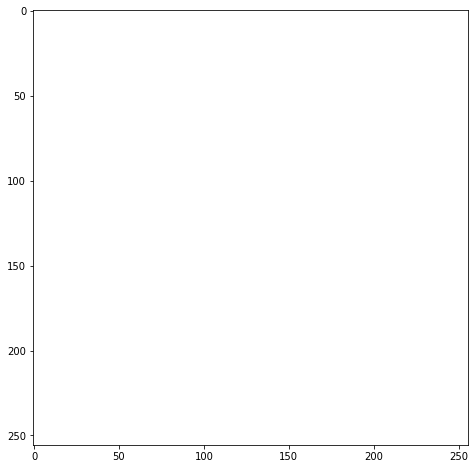

In [71]:
fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2): # axial view
    plt.imshow(imgs[0, :, :, i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:, :, i]==0, pred[:, :, i])
    plt.imshow(mask_, alpha=0.1, cmap="autumn")
#     plt.imshow(label_mask, alpha=0.5, cmap="jet")  # Uncomment if you want to see the label
    camera.snap()
    
animation = camera.animate()

In [72]:
HTML(animation.to_html5_video())